# Дипломный проект. Вариант 1
## Задание 1. Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)
Для начала импортируем библиотеку пандас, библиотеки для отображения графиков

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Создадим переменные с путями к файлам с данными

In [2]:
file_auth = "problem1-auth_data.zip"
file_reg = "problem1-reg_data.csv"

Прочитаем файлы с данными и запишем их в соответствующие датафреймы

In [3]:
df_auth = pd.read_csv(file_auth, sep=';')
df_reg = pd.read_csv(file_reg, sep=';')

Посмотрим на датафреймы, убедимся что все считалось верно

In [4]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


Размер датафреймов

In [6]:
df_auth.shape

(9601013, 2)

In [7]:
df_reg.shape

(1000000, 2)

Посмотрим на количество уникальных uid пользователей в датафреймах

In [8]:
df_auth.uid.nunique()

1000000

In [9]:
df_reg.uid.nunique()

1000000

Можно сделать вывод что в датафрейме с данными о регистрации нет повторяющихся uid

Посмотрим на типы данных, чтобы убедится что все считалось верно

In [10]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [11]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

Создадим функцию для расчета retention. На вход она будет принимать следующие параметры: 2 датафрейма - с авторизацией и регистрацией игроков, дату, от которой будет начинаться расчет, дату окончания расчетов.
Возвращать функция будет датафрейм с посчитаным retention.
Для начала напишем и проверим шаги, а потом соберем их в одну функцию

Совмещаем датафреймы с аутентификацией и регистрацией. В данном примере первая аутентификация пользователя совпадает со временем регистрации, но такое может быть не всегда и не везде

In [12]:
df_ret = df_auth.merge(df_reg, how='left', on='uid')
df_ret.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


Приводим колонки с датой из юникс формата в формат год-месяц-день

In [13]:
df_ret['reg_ts'] = pd.to_datetime(pd.to_datetime(df_ret.reg_ts, unit='s').dt.date)
df_ret['auth_ts'] = pd.to_datetime(pd.to_datetime(df_ret.auth_ts, unit='s').dt.date)
df_ret.dtypes

auth_ts    datetime64[ns]
uid                 int64
reg_ts     datetime64[ns]
dtype: object

Оставляем записи с регистрацией от нужной даты и записи с аутентификацией до нужной даты. В функции на месте дат будут переменные с датой

In [14]:
df_ret = df_ret[(df_ret.reg_ts >= '2020-01-01') & (df_ret.auth_ts <= '2020-01-15')]

Создаем колонку с количеством дней между авторизацией и датой регистрации

In [15]:
df_ret['day'] = (df_ret['auth_ts'] - df_ret['reg_ts']).dt.days
df_ret

,auth_ts,uid,reg_ts,day
6183545,2020-01-01,716362,2020-01-01,0
6183553,2020-01-01,716364,2020-01-01,0
6183560,2020-01-01,716365,2020-01-01,0
6183566,2020-01-01,716366,2020-01-01,0
6183574,2020-01-01,716367,2020-01-01,0
...,...,...,...,...
6338308,2020-01-15,732321,2020-01-14,1
6338311,2020-01-15,734256,2020-01-15,0
6338315,2020-01-15,718428,2020-01-02,13
6338319,2020-01-15,734258,2020-01-15,0


Группируем датафрейм по датам регистрации и прошедшим дням с регистрации, считаем количество уникальных пользователей

In [16]:
df_group = df_ret.groupby(['reg_ts', 'day']).agg(users=('uid', 'nunique')).reset_index()
df_group

,reg_ts,day,users
0,2020-01-01,0,1061
1,2020-01-01,1,28
2,2020-01-01,2,48
3,2020-01-01,3,36
4,2020-01-01,4,60
...,...,...,...
115,2020-01-13,1,21
116,2020-01-13,2,48
117,2020-01-14,0,1084
118,2020-01-14,1,18


Создаем сводную таблицу: в качестве индекса будет дата регистрации, в качестве колонок - дни с момента регистрации, в качестве значений - количество пользователей

In [17]:
pivot = df_group.pivot_table(index='reg_ts', columns='day', values='users')
pivot

day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2020-01-01,1061.0,28.0,48.0,36.0,60.0,62.0,80.0,53.0,47.0,47.0,57.0,69.0,49.0,52.0,51.0
2020-01-02,1063.0,25.0,48.0,55.0,51.0,62.0,82.0,63.0,60.0,56.0,60.0,60.0,48.0,48.0,NaN
2020-01-03,1065.0,25.0,36.0,47.0,48.0,73.0,80.0,58.0,48.0,45.0,56.0,62.0,59.0,NaN,NaN
2020-01-04,1067.0,16.0,48.0,54.0,57.0,61.0,75.0,58.0,45.0,52.0,51.0,58.0,NaN,NaN,NaN
2020-01-05,1069.0,21.0,48.0,49.0,47.0,51.0,84.0,56.0,42.0,58.0,44.0,NaN,NaN,NaN,NaN
2020-01-06,1070.0,31.0,48.0,53.0,41.0,50.0,71.0,63.0,56.0,54.0,NaN,NaN,NaN,NaN,NaN
2020-01-07,1072.0,20.0,52.0,47.0,69.0,54.0,91.0,55.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1074.0,24.0,43.0,46.0,55.0,54.0,91.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1076.0,20.0,43.0,59.0,48.0,65.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее значения в таблице необходимо сделать относительными первой колонки. Для этого воспользуемся функцией divide, которая делит весь датафрейм на определенные значения. Будем делить поколоночно (axis=0) на первую колонку

In [18]:
pivot = pivot.divide(pivot[0], axis=0)
pivot

day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2020-01-01,1.0,0.026390,0.045240,0.033930,0.056550,0.058435,0.075401,0.049953,0.044298,0.044298,0.053723,0.065033,0.046183,0.049010,0.048068
2020-01-02,1.0,0.023518,0.045155,0.051740,0.047977,0.058325,0.077140,0.059266,0.056444,0.052681,0.056444,0.056444,0.045155,0.045155,NaN
2020-01-03,1.0,0.023474,0.033803,0.044131,0.045070,0.068545,0.075117,0.054460,0.045070,0.042254,0.052582,0.058216,0.055399,NaN,NaN
2020-01-04,1.0,0.014995,0.044986,0.050609,0.053421,0.057170,0.070291,0.054358,0.042174,0.048735,0.047798,0.054358,NaN,NaN,NaN
2020-01-05,1.0,0.019645,0.044902,0.045837,0.043966,0.047708,0.078578,0.052385,0.039289,0.054256,0.041160,NaN,NaN,NaN,NaN
2020-01-06,1.0,0.028972,0.044860,0.049533,0.038318,0.046729,0.066355,0.058879,0.052336,0.050467,NaN,NaN,NaN,NaN,NaN
2020-01-07,1.0,0.018657,0.048507,0.043843,0.064366,0.050373,0.084888,0.051306,0.056903,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1.0,0.022346,0.040037,0.042831,0.051210,0.050279,0.084730,0.050279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1.0,0.018587,0.039963,0.054833,0.044610,0.060409,0.066914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь отобразим тепловую карту на основе получившейся сводной таблицы

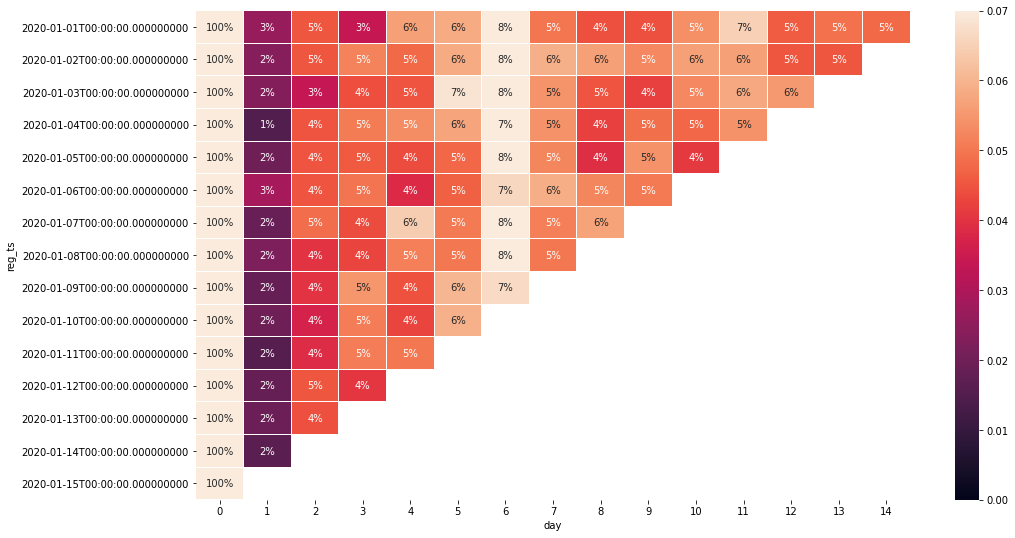

In [19]:
plt.rcParams['figure.figsize'] = [16, 9]
sns.heatmap(pivot, linewidth=.01, annot=True, fmt='.0%', vmin=0, vmax=0.07)

Осталось объединить шаги и создать функцию

In [20]:
def retention(df_auth, df_reg, start_date, end_date):
    # совмещаем датафреймы с аутентификацией и регистрацией
    df_ret = df_auth.merge(df_reg, how='left', on='uid')
    
    # приводим колонки с датой из юникс формата в формат год-месяц-день
    df_ret['reg_ts'] = pd.to_datetime(pd.to_datetime(df_ret.reg_ts, unit='s').dt.date)
    df_ret['auth_ts'] = pd.to_datetime(pd.to_datetime(df_ret.auth_ts, unit='s').dt.date)
    
    # выбираем только указанные даты
    df_ret = df_ret[(df_ret.reg_ts >= start_date) & (df_ret.auth_ts <= end_date)]
    
    # создаем колонку с количеством дней между авторизацией и датой регистрации
    df_ret['day'] = (df_ret['auth_ts'] - df_ret['reg_ts']).dt.days
    
    # группируем датафрейм
    df_group = df_ret.groupby(['reg_ts', 'day']).agg(users=('uid', 'nunique')).reset_index()
    
    # создаем сводную таблицу
    pivot = df_group.pivot_table(index='reg_ts', columns='day', values='users')
    
    # преобразуем значения в относительные
    pivot = pivot.divide(pivot[0], axis=0)
    
    # рисуем тепловую карту
    plt.rcParams['figure.figsize'] = [16, 9]
    sns.heatmap(pivot, linewidth=.01, annot=True, fmt='.0%', vmin=0, vmax=0.07)
    
    # возвращаем датафрейм с retention
    return pivot

Применяем функцию на практике и смотрим получившийся фрейм с данными

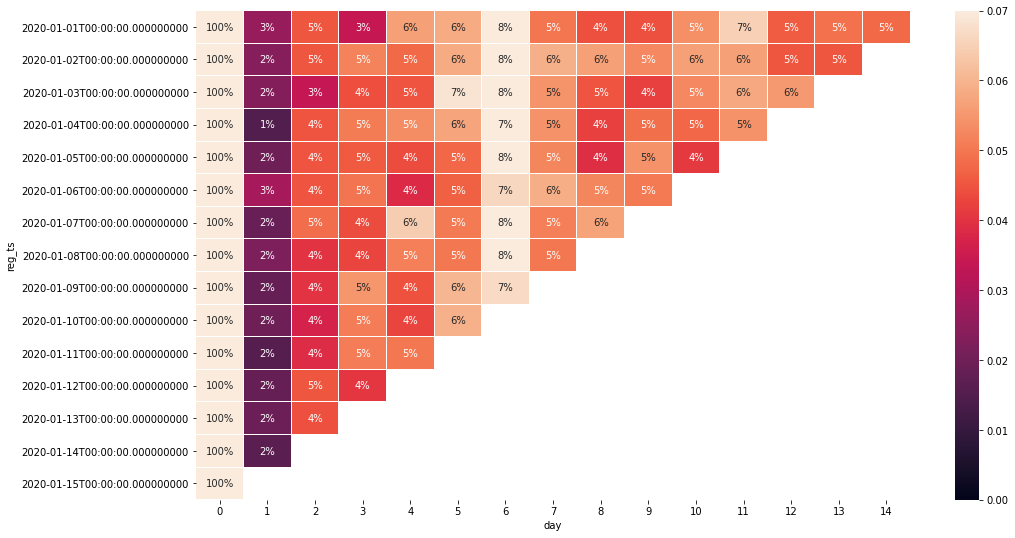

In [21]:
test = retention(df_auth, df_reg, '2020-01-01', '2020-01-15')

In [22]:
test

day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2020-01-01,1.0,0.026390,0.045240,0.033930,0.056550,0.058435,0.075401,0.049953,0.044298,0.044298,0.053723,0.065033,0.046183,0.049010,0.048068
2020-01-02,1.0,0.023518,0.045155,0.051740,0.047977,0.058325,0.077140,0.059266,0.056444,0.052681,0.056444,0.056444,0.045155,0.045155,NaN
2020-01-03,1.0,0.023474,0.033803,0.044131,0.045070,0.068545,0.075117,0.054460,0.045070,0.042254,0.052582,0.058216,0.055399,NaN,NaN
2020-01-04,1.0,0.014995,0.044986,0.050609,0.053421,0.057170,0.070291,0.054358,0.042174,0.048735,0.047798,0.054358,NaN,NaN,NaN
2020-01-05,1.0,0.019645,0.044902,0.045837,0.043966,0.047708,0.078578,0.052385,0.039289,0.054256,0.041160,NaN,NaN,NaN,NaN
2020-01-06,1.0,0.028972,0.044860,0.049533,0.038318,0.046729,0.066355,0.058879,0.052336,0.050467,NaN,NaN,NaN,NaN,NaN
2020-01-07,1.0,0.018657,0.048507,0.043843,0.064366,0.050373,0.084888,0.051306,0.056903,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,1.0,0.022346,0.040037,0.042831,0.051210,0.050279,0.084730,0.050279,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,1.0,0.018587,0.039963,0.054833,0.044610,0.060409,0.066914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Задание 2. Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Загрузим stats для проведения т-теста

In [23]:
from scipy import stats

Загрузим файл с данными

In [24]:
file = "~/shared/problem2.csv"

In [25]:
df = pd.read_csv(file, sep=';')

Посмотрим на типы данных

In [26]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Посмотрим на гистограмму распределения значений для обоих групп

In [27]:
plt.rcParams['figure.figsize'] = [16, 9]

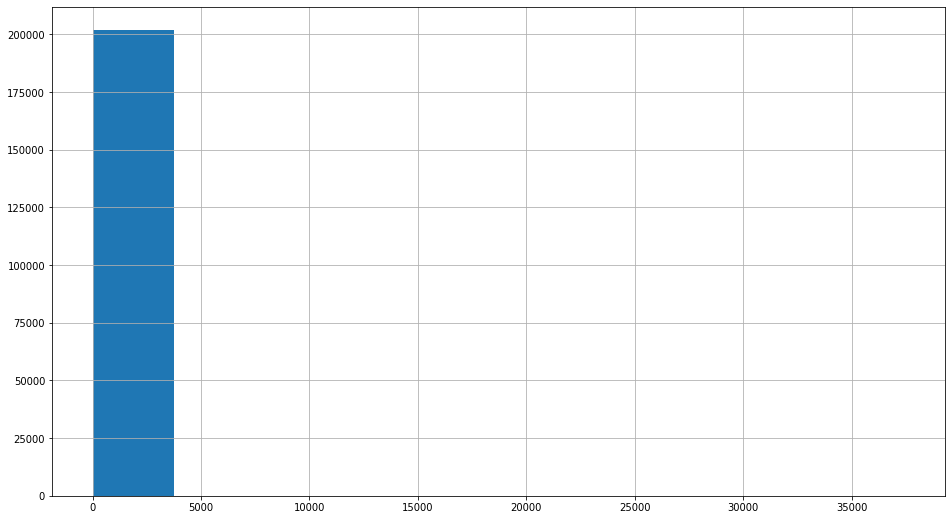

In [28]:
df[df.testgroup == 'a'].revenue.hist()

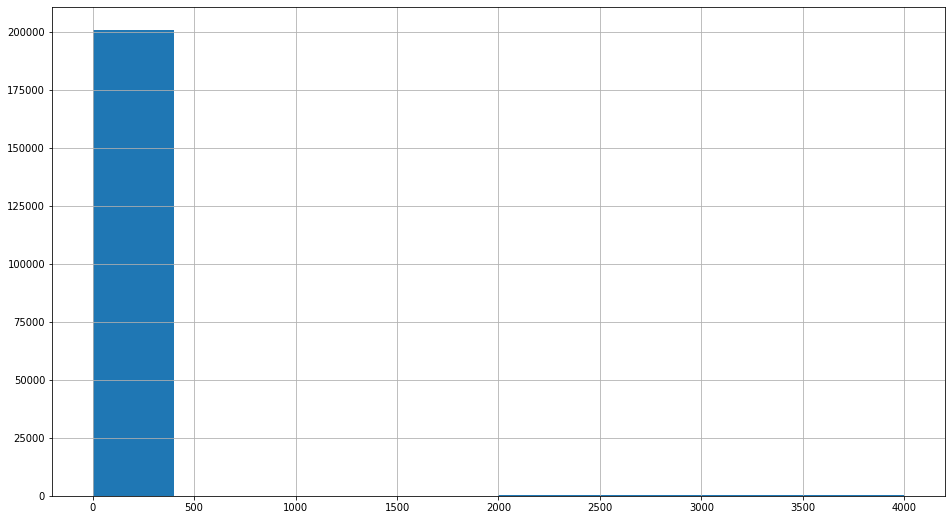

In [29]:
df[df.testgroup == 'b'].revenue.hist()

Из гистограмм становится понятно что в группе А существуют сильные выбросы, но проанализируем группы более подробно

Посмотрим подробно на группу А, количество каждых значений

In [30]:
df[df.testgroup == 'a'].revenue.value_counts()

0        200175
206          18
310          18
265          17
224          17
          ...  
37379         1
37341         1
37347         1
37407         1
37357         1
Name: revenue, Length: 269, dtype: int64

In [31]:
df[(df.testgroup == 'a')].revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Видим, что существуют выбросы очень больших значений, и значение 0 составляет львиную долю данных. Посмотрим на распределения без нулевых значений

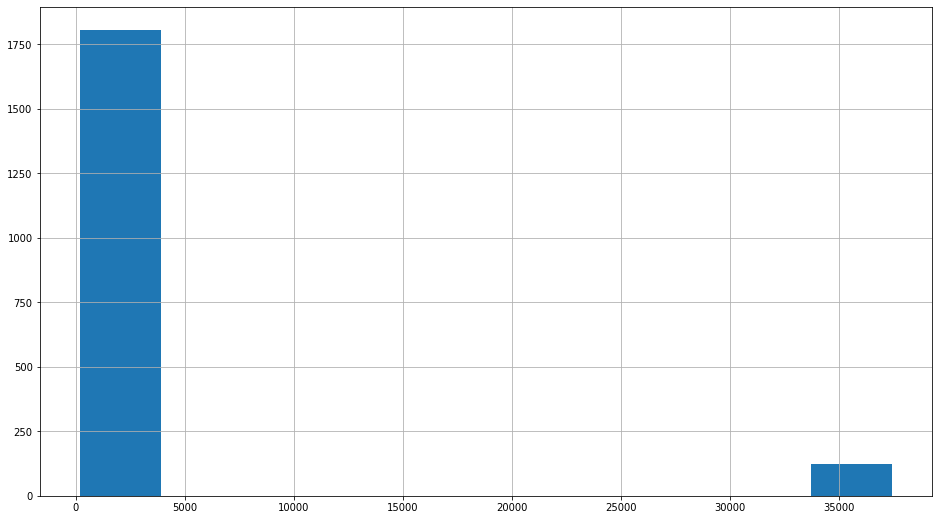

In [32]:
df[(df.testgroup == 'a') & (df.revenue > 0)].revenue.hist()

Посмотрим на данные группы А со значениями выше или равными 1000

In [33]:
df[(df.testgroup == 'a') & (df.revenue >= 1000)].revenue.value_counts()

37295    5
37302    4
37294    4
37296    4
37297    4
        ..
37328    1
37327    1
37325    1
37324    1
37379    1
Name: revenue, Length: 67, dtype: int64

In [34]:
df[(df.testgroup == 'a') & (df.revenue >= 1000)].revenue.count()

123

Теперь на данные группы А со значениями в промежутке от 0 до 1000

In [35]:
df[(df.testgroup == 'a') & (df.revenue > 0) & (df.revenue < 1000)].revenue.value_counts()

206    18
310    18
397    17
265    17
224    17
       ..
395     4
245     2
392     2
330     2
225     2
Name: revenue, Length: 201, dtype: int64

In [36]:
df[(df.testgroup == 'a') & (df.revenue > 0) & (df.revenue < 1000)].revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

По итогам наблюдений можно сделать вывод что в группе А присутствуют 123 значения с сильными выбросами, остальные значения больше нуля лежат в промежутке от 200 до 400, их 1805

Далее посмотрим значения группы Б

In [37]:
df[(df.testgroup == 'b')].revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [38]:
df[df.testgroup == 'b'].revenue.value_counts()

0       200862
2003         6
3359         5
3367         4
3410         4
         ...  
3150         1
3022         1
2894         1
3535         1
2114         1
Name: revenue, Length: 1209, dtype: int64

Посмотрим на значения > 0

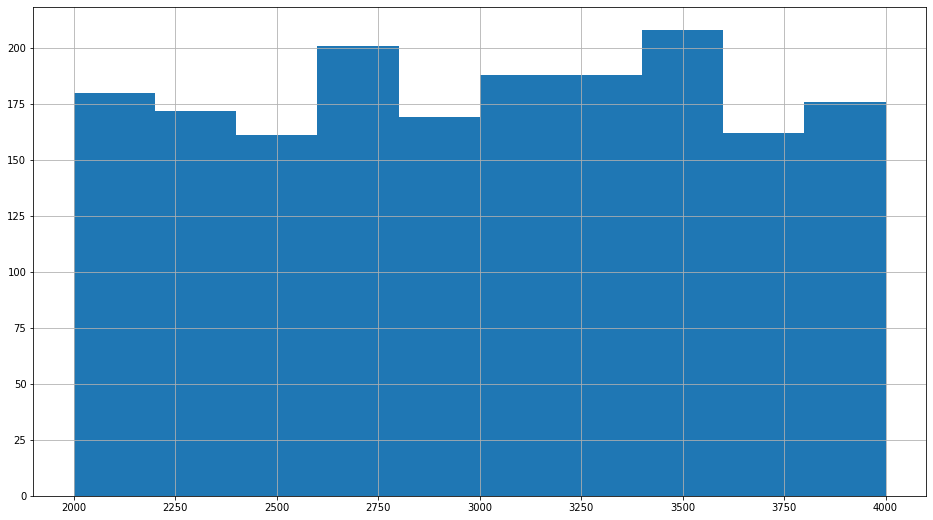

In [39]:
df[(df.testgroup == 'b') & (df.revenue > 0)].revenue.hist()

In [40]:
df[(df.testgroup == 'b') & (df.revenue > 0)].revenue.value_counts()

2003    6
3359    5
2709    4
2903    4
2225    4
       ..
3197    1
3196    1
3186    1
3185    1
2051    1
Name: revenue, Length: 1208, dtype: int64

In [41]:
df[(df.testgroup == 'b') & (df.revenue > 0)].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Мы видим что значений больше нуля в группе Б 1805, располагаются в промежутке от 2000 до 4000


Поскольку распределение в группе А имеет сильные выбросы, попробуем сравнить 2 группы, используя тест Манна-Уитни

In [42]:
stats.mannwhitneyu(df[df.testgroup == 'a'].revenue, df[df.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p=0.06, и говорит что мы не может отклонить нулевую гипотезу что две группы разные

Посмотрим на группу А без выбросов

In [43]:
df[(df.testgroup == 'a') & (df.revenue < 10000)].revenue.describe()

count    201980.000000
mean          2.702926
std          28.985815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         400.000000
Name: revenue, dtype: float64

Видим что без значений выброса группа А имеет среднее намного меньше группы Б

Проведем т-тест группы Б и А без выбросов. Поскольку выбросов нет, будем использовать стандартный т-тест

In [44]:
stats.ttest_ind(df[(df.testgroup == 'a') & (df.revenue < 10000)].revenue, df[(df.testgroup == 'b')].revenue)

Ttest_indResult(statistic=-37.42623596967759, pvalue=4.912187544972622e-306)

Видим что p сильно меньше 0.05, и группы отличаются друг от друга.

Вывод: Группа А имеет 123 значения, которые очень сильно отличаются от остальных, природа появления которых неизвестна (это может быть ошибка в бд и т.д.). Поэтому логичнее было бы сравнивать группы А и Б без сильных выбросов. В группе Б arpu в разы больше, чем в группе А без выбросов, поэтому набор предложений Б можно считать лучшим

## Задание 3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Для начала, опредилим метрики, помогающие нам оценить результаты:
1. Ид уровня - чтобы знать какой именно уровень проходил игрок
2. Дата и время начала прохождения уровня - начало прохождения уровня
3. Дата и время окончания прохождения уровня - конец прохождения уровня
4. Время на уровень - сколько игрок затратил времени на прохождение уровня, п.2 - п.3
5. Ид тематического события, к которому относится прохождение - чтобы отсеивать данные по событию

## Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Можно добавить метрику последнего пройденного уровня, от которого считать куда пользователь будет откатываться при неудачной попытке